In [2]:
import os
import cv2
import time
import pickle
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

# tensorflow
import tensorflow

# sklearn
import sklearn
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA # Dimensionality Reduction

# pytorch
import torch
import torchvision
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data import random_split, Dataset,DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [3]:
options={
  0: "with_mask",
  1: "without_mask",
  2: "mask_weared_incorrect"
}
IMG_SIZE = 64
DATA_PATH = '../input/facemaskdataset/'

In [6]:
pickle_in = open(DATA_PATH+"datasets/X.pickle", "rb")
pX = pickle.load(pickle_in)
pickle_in = open(DATA_PATH+"datasets/y.pickle", "rb")
pY = pickle.load(pickle_in)
pickle_in = open(DATA_PATH+"datasets/data.pickle", "rb")
data = pickle.load(pickle_in)

In [7]:
print('Shape of X:', pX.shape)
print('Shape of y:', pY.shape)
print('Shape of data:', data.shape)

Shape of X: (18858, 64, 64)
Shape of y: (18858,)
Shape of data: (18858, 4096)


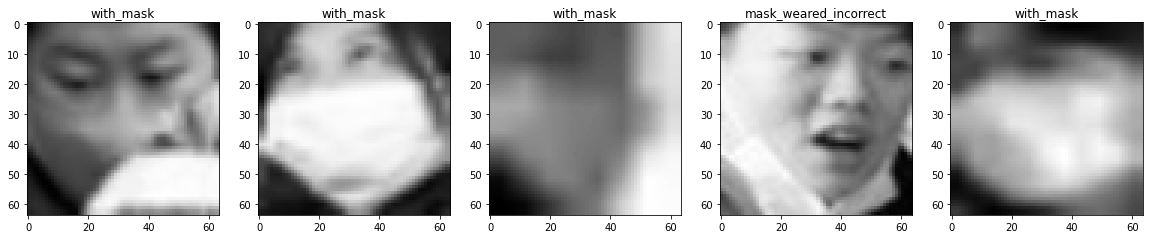

In [5]:
plt.figure(figsize=(20,10))
columns = 5
for i in range(5):
  id = random.randint(0, 100)
  plt.subplot(int(5 / columns) + 1, columns, i + 1)
  plt.imshow(pX[id], cmap='gray')
  plt.title(options[pY[id]], color='black')

In [6]:
resized_X = []
for img in pX:
  resized_X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))

In [7]:
X = np.asarray(resized_X)
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
print(X.shape)

(18858, 64, 64, 1)


In [8]:
# normalize the pixel values
X = X / 255.0
IMG_DIM = X.shape[1]
y = pY
print('IMG_DIM:',IMG_DIM)

IMG_DIM: 64


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('Training Size:', len(X_train))
print('Testing  Size:', len(X_test))

Training Size: 15086
Testing  Size: 3772


In [24]:
# Building and fitting the CNN Model
cnn_model = tensorflow.keras.models.Sequential()
# Start of Convolution Layers & Maxpooling
cnn_model.add(tensorflow.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(IMG_DIM, IMG_DIM, 1)))
cnn_model.add(tensorflow.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn_model.add(tensorflow.keras.layers.MaxPool2D())

cnn_model.add(tensorflow.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn_model.add(tensorflow.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn_model.add(tensorflow.keras.layers.MaxPool2D())

cnn_model.add(tensorflow.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(IMG_DIM, IMG_DIM, 1)))
cnn_model.add(tensorflow.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn_model.add(tensorflow.keras.layers.MaxPool2D())

# Start of Neural Nets
cnn_model.add(tensorflow.keras.layers.Flatten())

cnn_model.add(tensorflow.keras.layers.Dense(512, activation='relu'))
cnn_model.add(tensorflow.keras.layers.Dropout(0.3))
cnn_model.add(tensorflow.keras.layers.Dense(512, activation='relu'))
cnn_model.add(tensorflow.keras.layers.Dropout(0.3))
cnn_model.add(tensorflow.keras.layers.Dense(256, activation='relu'))
cnn_model.add(tensorflow.keras.layers.Dense(128, activation='relu'))
cnn_model.add(tensorflow.keras.layers.Dense(3, activation='softmax'))


In [25]:
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 11, 11, 64)       

In [27]:
cnn_model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

In [28]:
# Train Model
epochs = 10
cnn_model.fit(X_train, y_train, epochs=epochs, validation_split=0.1)

Epoch 1/10
425/425 [==============================] - 5s 10ms/step - loss: 0.5604 - acc: 0.7441 - val_loss: 0.2468 - val_acc: 0.9092
Epoch 2/10
425/425 [==============================] - 4s 10ms/step - loss: 0.2292 - acc: 0.9158 - val_loss: 0.1666 - val_acc: 0.9364
Epoch 3/10
425/425 [==============================] - 4s 10ms/step - loss: 0.1777 - acc: 0.9374 - val_loss: 0.1315 - val_acc: 0.9529
Epoch 4/10
425/425 [==============================] - 4s 10ms/step - loss: 0.1448 - acc: 0.9480 - val_loss: 0.1449 - val_acc: 0.9404
Epoch 5/10
425/425 [==============================] - 4s 10ms/step - loss: 0.1198 - acc: 0.9566 - val_loss: 0.1565 - val_acc: 0.9450
Epoch 6/10
425/425 [==============================] - 4s 10ms/step - loss: 0.1068 - acc: 0.9595 - val_loss: 0.1166 - val_acc: 0.9649
Epoch 7/10
425/425 [==============================] - 4s 10ms/step - loss: 0.0931 - acc: 0.9666 - val_loss: 0.1215 - val_acc: 0.9596
Epoch 8/10
425/425 [==============================] - 4s 10ms/step - 

In [29]:
cnn_model.evaluate(X_test, y_test)

118/118 [==============================] - 0s 4ms/step - loss: 0.0803 - acc: 0.9692


[0.08027583360671997, 0.9692471027374268]

In [30]:
y_pred = np.argmax(cnn_model.predict(X_test), axis=-1)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1851
           1       0.96      0.97      0.96      1305
           2       0.97      0.99      0.98       616

    accuracy                           0.97      3772
   macro avg       0.97      0.97      0.97      3772
weighted avg       0.97      0.97      0.97      3772



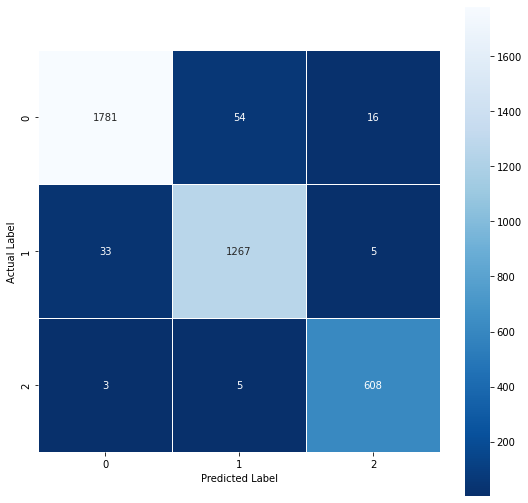

In [31]:
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt='.0f', square=True, linewidths=.5, cmap='Blues_r')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

print(sklearn.metrics.classification_report(y_test, y_pred))

In [22]:
tensorflow.keras.models.save_model(cnn_model, 'cnn_kaggle.h5')

# KNN

## Performance of Best Params

In [32]:
best_params = {'weights': 'distance', 'n_neighbors': 2, 'metric': 'manhattan'}

In [37]:
# Get Column Names
cols = []
for i in range(0, len(data[0])):
    cols.append("P" + str(i))

# Convert to Dataframe
numpy_data = data
X = pd.DataFrame(data=numpy_data, columns=[cols])
print(X.head())

y = pd.DataFrame(data=y, columns=["target"])
print(y.head())

    P0   P1   P2   P3   P4   P5   P6   P7   P8   P9  ... P4086 P4087 P4088  \
0   95  105  116  126  139  146  137  125  117  117  ...    26    29    28   
1  101  101  101  100   99   99   97   94   90   87  ...    29    29    30   
2   73   65   68   72   76   79   75   72   64   56  ...    22    22    24   
3  202  200  201  200  202  201  194  186  190  197  ...    72    81    89   
4   65   70   79   93  106  118  145  172  194  212  ...    18    16     7   

  P4089 P4090 P4091 P4092 P4093 P4094 P4095  
0    24    20    19    19    22    27    31  
1    29    28    28    34    41    47    51  
2    27    29    31    31    34    38    34  
3    85    70    59    60    69    79    84  
4     7    11    12    12    10    11    12  

[5 rows x 4096 columns]
   target
0       0
1       0
2       0
3       0
4       2


In [38]:
# Split our data into testing and training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# Print the length and width of our testing data.
print('Length of our Training data: ', len(X_train), '\nLength of our Testing data: ', len(X_test))

Length of our Training data:  15086 
Length of our Testing data:  3772


In [40]:
# create new a knn model with best params
b_knn = KNeighborsClassifier(**best_params)

#fit model to data
b_knn.fit(X_train, y_train.values.ravel())

# make prediction on entire test data
train_pred = b_knn.predict(X_train)

# make prediction on entire test data
y_pred = b_knn.predict(X_test)

print('Accuracy Train: %.3f' % accuracy_score(y_train, train_pred))
print('Accuracy Test: %.3f' % accuracy_score(y_test, y_pred))
print("\nClassification Report\n", classification_report(y_test, y_pred))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Accuracy Train: 1.000
Accuracy Test: 0.874

Classification Report
               precision    recall  f1-score   support

           0       0.92      0.83      0.87      1829
           1       0.83      0.88      0.85      1314
           2       0.86      0.98      0.91       629

    accuracy                           0.87      3772
   macro avg       0.87      0.90      0.88      3772
weighted avg       0.88      0.87      0.87      3772



Text(0.5, 1.0, 'Accuracy Score Best Params: 0.8743372216330859')

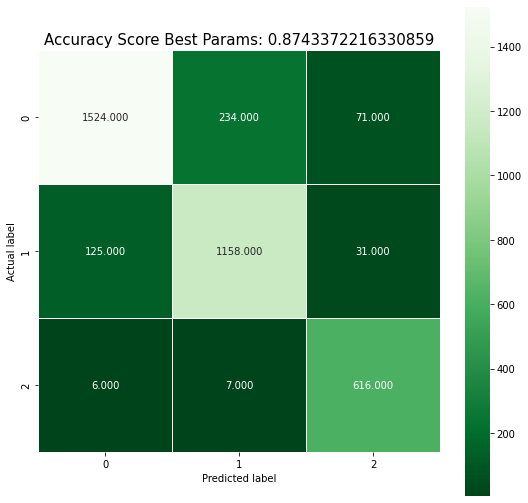

In [41]:
# Calculate Confusion Matrix for Best Param Model
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
# Heatmap visualization of accuracy
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Greens_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Accuracy Score Best Params: {0}'.format(accuracy_score(y_test, y_pred))
plt.title(title,size=15)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
def get_mean_std(loader):
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [5]:
mean, std = [0.6583, 0.4580, 0.0877], [0.2412, 0.2313, 0.2387]
BATCH_SIZE, LEARNING_RATE, NUM_EPOCH, WEIGHT_DECAY = 64, 1e-3, 10, 1e-4

In [6]:
train_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize(mean=mean,std=std)])
augment_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    torchvision.transforms.RandomHorizontalFlip(p=1),
    torchvision.transforms.RandomRotation(20, resample=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)
])

dataset = datasets.ImageFolder(DATA_PATH+"data/data", transform = train_transforms)
augmented_dataset = datasets.ImageFolder(DATA_PATH+"data/data", transform = augment_transforms)
dataset = torch.utils.data.ConcatDataset([augmented_dataset,dataset])

dataset_size = len(dataset)
train_size, val_size = int(dataset_size * 0.6),  int(dataset_size * 0.2)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f'Dataset size: {dataset_size}\nTrain set size: {len(train_dataset)}\nValidation set size: {len(val_dataset)}\nTest set size: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:1231: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Dataset size: 45860
Train set size: 27516
Validation set size: 9172
Test set size: 9172


In [7]:
models = {
    'vgg16': torchvision.models.vgg16(),
    'vgg19': torchvision.models.vgg19(),
    'resnet18': torchvision.models.resnet18(),
    'resnet34': torchvision.models.resnet34(),
    'resnet50': torchvision.models.resnet50(),
    'densenet': torchvision.models.densenet161(),
    'mobilenet': torchvision.models.mobilenet_v2(),
    'mobilenet_small': torchvision.models.mobilenet_v3_small(),
    'mobilenet_large': torchvision.models.mobilenet_v3_large()
}

def collate_fn(batch) : return tuple(zip(*batch))

In [8]:
def get_model(model_name, output_shape=3):
    model = models[model_name]
    
    if 'fasterrcnn' in model_name:
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, output_shape)
    elif "resnet" in model_name:
        in_features = model.fc.in_features
        last_layer = torch.nn.Linear(in_features, output_shape)
        model.fc.out_features = last_layer
    elif model_name == 'mobilenet':
        model.classifier._modules['1'] = torch.nn.Linear(1280, output_shape)
    elif 'vgg' in model_name:
        model.classifier._modules['6'] = torch.nn.Linear(4096, output_shape3)
    elif model_name == 'densenet':
        model.classifier = torch.nn.Linear(2208, output_shape)
    
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)

    model.to(device)
    return model

In [9]:
model = torchvision.models.resnet50(pretrainted=True) #get_model('resnet50')
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1)

In [11]:
def save_loss_fig(NUM_EPOCH, training_losses, val_losses):
    plt.figure(1)
    plt.plot(range(NUM_EPOCH), training_losses, label='Training')
    plt.plot(range(NUM_EPOCH), val_losses, label='Validation')
    plt.title("Training Loss vs Validation Loss")
    plt.xlabel("Epoch Number")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig("losses")

def save_accuracy_fig(NUM_EPOCH, training_accuracies, val_accuracies):
    plt.figure(2)
    plt.plot(range(NUM_EPOCH), training_accuracies, label='Training')
    plt.plot(range(NUM_EPOCH), val_accuracies, label='Validation')
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.xlabel("Epoch Number")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig("accuracies")

EPOCH:0, Training Loss:0.007641662671990928, Validation Loss:0.005758459116439865, Training Accuracy: 0.8135993603721471, Validation Accuracy: 0.8578281726995203
Model saved
0.001
EPOCH:1, Training Loss:0.003965765281944172, Validation Loss:0.005189813428176214, Training Accuracy: 0.9081261811309783, Validation Accuracy: 0.8669864805931095
Model saved
0.001
EPOCH:2, Training Loss:0.0031064097569322045, Validation Loss:0.0028019781588754225, Training Accuracy: 0.9257522895769734, Validation Accuracy: 0.93512865242041
Model saved
0.001
EPOCH:3, Training Loss:0.002575104146370501, Validation Loss:0.003268627336145591, Training Accuracy: 0.9400712312836168, Validation Accuracy: 0.9205189707806367
0.001
EPOCH:4, Training Loss:0.0023893018365924415, Validation Loss:0.004366331864952573, Training Accuracy: 0.9438145079226632, Validation Accuracy: 0.8959877889228085
0.0001
EPOCH:5, Training Loss:0.0012863281350722286, Validation Loss:0.0011022580233437074, Training Accuracy: 0.9710350341619421

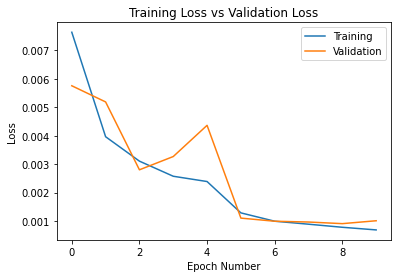

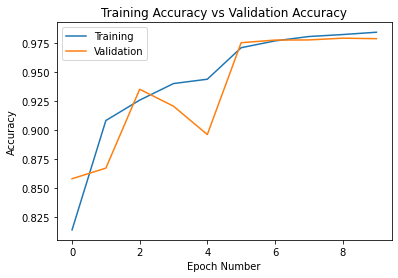

In [12]:
def train(model, best_model):
    training_losses, val_losses, training_accuracies, validation_accuracies = [], [], [], []

    for epoch in range(NUM_EPOCH):
        epoch_train_loss, correct, train_total = 0,0,0

        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            
            optimizer.zero_grad()
            result = model(X)
            loss = criterion(result, y)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            _, maximum = torch.max(result.data, 1)
            train_total += y.size(0)
            correct += (maximum == y).sum().item()
        
        training_accuracy = correct / train_total
        training_losses.append(epoch_train_loss / train_total)
        training_accuracies.append(training_accuracy)

        epoch_val_loss, correct, total = 0,0,0
        
        with torch.no_grad():
            model.eval()
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                 
                result = model(X)
                loss = criterion(result, y)
                epoch_val_loss += loss.item()
                _, maximum = torch.max(result.data, 1)
                total += y.size(0)
                correct += (maximum == y).sum().item()
                
        val_losses.append(epoch_val_loss / total)
        accuracy = correct/total
        validation_accuracies.append(accuracy)
        print(f'EPOCH:{epoch}, Training Loss:{epoch_train_loss / train_total}, Validation Loss:{epoch_val_loss / total}, Training Accuracy: {training_accuracy}, Validation Accuracy: {accuracy}')
        
        if min(val_losses) == val_losses[-1]:
            checkpoint = {'model': model, 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}
            torch.save(checkpoint, best_model)
            print("Model saved")

        scheduler.step(epoch_val_loss)
        print(optimizer.state_dict()['param_groups'][0]['lr'])

    save_loss_fig(NUM_EPOCH, training_losses, val_losses)
    save_accuracy_fig(NUM_EPOCH, training_accuracies, validation_accuracies)

best_model = "models/best_model.pth"
start_time = time.time()
train(model, best_model)
end_time = time.time()
duration = end_time - start_time
print(f'Time it takes to train {duration}')

In [13]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    return model.eval()

In [14]:
def test(model, test_loader):
    correct, total = 0, 0
        
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)

            result = model(X)
            _, maximum = torch.max(result.data, 1)
            total += y.size(0)
            correct += (maximum == y).sum().item()

    accuracy = correct/total
    print(f'Testing Accuracy: {accuracy}')

loaded_model = load_checkpoint(best_model)
test(loaded_model, test_loader)

Testing Accuracy: 0.9799389446140427
